In [1]:
from datetime import date
from prophet import Prophet
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf
df = pd.read_csv("../Resources/btcjoin.csv", parse_dates=['date'])
btc_df = yf.download('BTC-USD')
btc_df = btc_df.reset_index()
btc_df = btc_df.loc[(btc_df['Date'] > '2022-10-25')]
btc_df['Close']=btc_df['Close'].astype("float")
df['price']=df['price'].str.replace(',','')
df['price']=df['price'].astype("float")
btc_df = btc_df.rename(columns={"Close": "price", "Date":"date"})
df = pd.merge(df, btc_df, on=['date', 'price'], how='outer')
df = df.rename(columns={"value": "wallets"})
df = df.drop(columns=['volume','change', 'low', 'high', 'open','Open','High','Low','Adj Close', 'Volume', 'Unnamed: 0', "wallets", "address", "mined"])
df['200D'] = df['price'].rolling(200).mean()
df['300D'] = df['price'].rolling(300).mean()
df['50D'] = df['price'].rolling(50).mean()
df = df.dropna()
df['meanavge'] = (df['200D'] + df['300D'] + df['50D'] )/3
df = df.drop(columns=['200D','300D', '50D'])
df['meanvalue'] = df["price"] - df["meanavge"]
df['status'] = df['meanvalue'].apply(lambda x: '1' if x > 0 else '0')
df['status']=df['status'].astype("object")
df['price-meanavge']=df['price'] - df['meanavge']
df['move%'] = df['price-meanavge']/(df['price'] + df['meanavge'])
bins = [-0.43, -0.1, 0, 0.1, 0.43]
group_names = ["Severely Oversold","Neutral Oversold", "Neutral Overbought","Severely Overbought"]
df["Valuation"] = pd.cut(df["move%"], bins, labels=group_names)


[*********************100%***********************]  1 of 1 completed


10:56:06 - cmdstanpy - INFO - Chain [1] start processing
10:56:11 - cmdstanpy - INFO - Chain [1] done processing


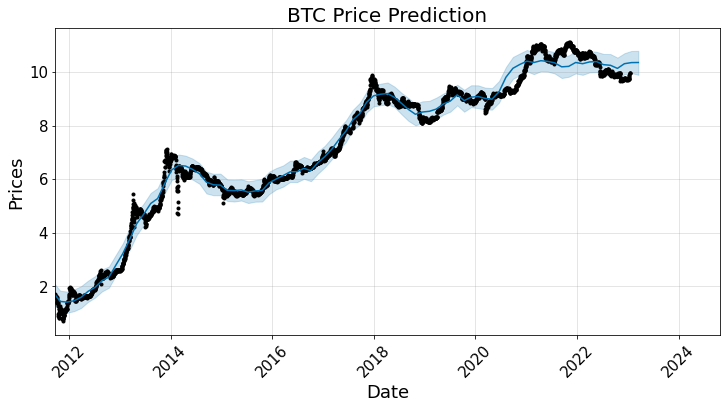

In [2]:
## Combine with Prophet
from datetime import timedelta, date
from prophet import Prophet
df['priceL'] = np.log(df['price'])

df_train = df[['date', 'priceL']]
df_train = df_train.rename(columns = {"date":"ds", "priceL":"y"})

# instantiate the model and set parameters
model = Prophet()

# fit the model to historical data
model.fit(df_train);

start = "2010-09-25"
end = date.today() + timedelta(days=60)
insample = pd.DataFrame(pd.date_range(start,end, periods=92))

# Change the column name
insample.columns = ['ds']

# in-sample prediction
prediction = model.predict(insample)

# Plot
fig = model.plot(prediction, figsize=(10,5))
ax = fig.gca()
ax.set_title("BTC Price Prediction", size=20)
ax.set_xlabel("Date", size=18)
ax.set_ylabel("Prices", size=18)
ax.tick_params(axis='y', labelsize=15)
ax.tick_params(axis='x', rotation=45, labelsize=15)
ax.set_xlim(pd.to_datetime(['2011-09-25', '2024-10-24'])) 
plt.show();

In [3]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","red","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/combo.html')

In [4]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.bar(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","red","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Buy Zones 2.0')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)
fig.update_layout(showlegend=True)
fig.update_traces(dict(marker_line_width=.01))
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/buyzones2.html')

In [5]:
from datetime import date
from datetime import datetime

d1 = str(int(df.price[df['date']=='2014-01-06'].tolist()[0]/df.price[df['date']=='2011-11-25'].tolist()[0]*100)) +"%"
d2 = str(int(-100*(1-(df.price[df['date']=='2015-10-05'].tolist()[0]/df.price[df['date']=='2014-01-07'].tolist()[0])))) + "%"
d3 = str(int(df.price[df['date']=='2018-01-06'].tolist()[0]/df.price[df['date']=='2015-10-06'].tolist()[0]*100)) +"%"
d4 = str(int(-100*(1-(df.price[df['date']=='2019-03-30'].tolist()[0]/df.price[df['date']=='2018-01-07'].tolist()[0])))) + "%"
d5 = str(int(df.price[df['date']=='2021-11-08'].tolist()[0] / df.price[df['date']=='2019-04-01'].tolist()[0] *100)) + "%"
d6 = str(int(-100*(1-(df.price[df['date']== df.date.iloc[-1]].tolist()[0]/df.price[df['date']=='2021-11-09'].tolist()[0])))) + "%"

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="Valuation", color_discrete_sequence=["green","blue","red","orange"],
                 title="price")
fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.add_vrect(x0="2011-11-25", x1="2014-01-06", 
              annotation_text=str((date(2014, 2, 4)-date(2011, 11, 25)).days) + " days " + str(d1), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-01-07", x1="2015-10-05", 
              annotation_text=str((date(2015, 10, 7)-date(2014, 2, 5)).days) + " days " + str(d2), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-06", x1="2018-01-06", 
              annotation_text=str((date(2018, 1, 18)-date(2015, 10, 6)).days) +" days " + str(d3), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-01-07", x1="2019-03-30", 
              annotation_text=str((date(2019, 3, 30)-date(2018, 1, 18)).days) + " days " + str(d4), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-01", x1="2021-11-08", 
              annotation_text=str((date(2021, 11, 8)-date(2019, 4, 1)).days) + " days " + str(d5), annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-09", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today() -date(2021, 11, 8)).days) + " days " + str(d6), annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Prophet Model + Buy Zones + Bull/Bear')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=12)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=15, t=70, b=20),
)
fig.add_vline(x='2012-11-28', line_width=1, line_dash="dash", line_color="black")
fig.add_vline(x='2016-07-09', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2020-05-11', line_width=1, line_dash="dash", line_color="black")	
fig.add_vline(x='2024-04-02', line_width=1, line_dash="dash", line_color="black")	
fig.show()
fig.layout.template = 'seaborn'
fig.write_html('../static/combodates.html')

In [6]:
df['status'] = df['status'].replace({'0': 'Undervalue'})
df['status'] = df['status'].replace({'1': 'Overvalued'})

In [7]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Time To Reach Previous ATH')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus.html')

In [8]:
## Approximate date/time to reach previous ATH

import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))
# fig.add_trace(go.Scatter(name="Middle Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat']), legendrank=2))
# fig.add_trace(go.Scatter(name="Lower Bound", x=prediction['ds'],  mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_lower']), legendrank=1))
# fig.add_trace(go.Scatter(name="Upper Bound", x=prediction['ds'], mode = 'lines',line=dict(width=1,color='darkred'), y=np.exp(prediction['yhat_upper']), legendrank=1))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Cycle Tops')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2017-03-17", x1="2013-11-29", 
              annotation_text=str((date(2017, 3, 17)-date(2013, 11, 29)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2017-12-17", x1="2020-11-30", 
              annotation_text=str((date(2020, 11, 30)-date(2017, 12, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-10-22", 
              annotation_text=str((date(2024, 10, 22) - date.today()).days) + " days previous ATH", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="blue", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))


fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/approximatenextath.html')

In [9]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.scatter(df, x="date", y="price", color="status", color_discrete_sequence=["red", "orange"], trendline="expanding", trendline_options=dict(function="max"), 
                 title="price")

fig.add_trace(go.Scatter(name="MeanAvg", x=df['date'], y=df['meanavge'], marker = {'color' : 'black'}, legendrank=2))

fig.update_yaxes(fixedrange=False)
fig.update_layout(title_text='Bitcoin Expanding Mean + Meanaverage')
fig.update_yaxes(type="log")
fig.update_xaxes(ticklabelposition="inside top", title="Date")
fig.update_yaxes(nticks=15)
fig.update_xaxes(nticks=50)
fig.update_layout(
    margin=dict(l=20, r=100, t=70, b=20),
)

fig.add_vrect(x0="2011-09-04", x1="2012-05-16", 
              annotation_text=str((date(2012, 5, 16)-date(2011, 9, 4)).days) + " days", annotation_position="top left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2012-05-17", x1="2014-02-10", 
              annotation_text=str((date(2014, 2, 10)-date(2012, 5, 17)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2014-02-11", x1="2015-10-06", 
              annotation_text=str((date(2015, 10, 6)-date(2014, 2, 11)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2015-10-07", x1="2018-02-18", 
              annotation_text=str((date(2018, 2, 18)-date(2015, 10, 7)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2018-02-19", x1="2019-04-02", 
              annotation_text=str((date(2019, 4, 2)-date(2018, 2, 19)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0="2019-04-03", x1="2021-11-07", 
              annotation_text=str((date(2021, 11, 7)-date(2019, 4, 3)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="green", opacity=0.25, line_width=0)
fig.add_vrect(x0="2021-11-08", x1=(f'{datetime.today():%Y-%m-%d}'), 
              annotation_text=str((date.today()-date(2021, 11, 8)).days) + " days", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="orange", opacity=0.25, line_width=0)
fig.add_vrect(x0=(f'{datetime.today():%Y-%m-%d}'), x1="2024-04-02", 
              annotation_text=str((date(2024, 4, 2)-date.today()).days) + " days halving", annotation_position="bottom left",
              annotation=dict(font_size=15, font_family="Times New Roman"),
              fillcolor="red", opacity=0.25, line_width=0)

fig.add_trace(go.Scatter(
    x=[(date(2021, 11, 8)),(date(2021, 11, 8) +timedelta(days=1079))],
    y=[df.price[df['price']==df.price.max()].tolist()[0],df.price[df['price']==df.price.max()].tolist()[0]],
    mode="markers+text+lines",
    name="Lines and Text",
    text=[ " ",str(df.price[df['price']==df.price.max()].tolist()[0]) + " " + str((date(2021, 11, 8) +timedelta(days=1079)))],
    textposition="bottom center"
))
        

fig.update_layout(showlegend=False)
fig.add_vline(x='2012-11-28', line_width=3, line_dash="dash", line_color="green")
fig.add_vline(x='2016-07-09', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2020-05-11', line_width=3, line_dash="dash", line_color="green")	
fig.add_vline(x='2024-04-02', line_width=3, line_dash="dash", line_color="green")	
fig.layout.template = 'seaborn'
fig.show()
fig.write_html('../static/Bitcoinvaluestatus2.html')

In [10]:
df['change'] = df.price.diff()

In [11]:
df

,date,price,meanavge,meanvalue,status,price-meanavge,move%,Valuation,priceL,change
299,2011-07-21,13.600000,8.704611,4.895389,Overvalued,4.895389,0.219479,Severely Overbought,2.610070,NaN
300,2011-07-22,13.700000,8.762722,4.937278,Overvalued,4.937278,0.219799,Severely Overbought,2.617396,0.100000
301,2011-07-23,13.700000,8.796167,4.903833,Overvalued,4.903833,0.217985,Severely Overbought,2.617396,0.000000
302,2011-07-24,14.000000,8.801778,5.198222,Overvalued,5.198222,0.227974,Severely Overbought,2.639057,0.300000
303,2011-07-25,14.100000,8.823000,5.277000,Overvalued,5.277000,0.230205,Severely Overbought,2.646175,0.100000
...,...,...,...,...,...,...,...,...,...,...
4464,2023-01-12,18869.587891,20329.452689,-1459.864798,Undervalue,-1459.864798,-0.037242,Neutral Oversold,9.845307,934.691406
4465,2023-01-13,19909.574219,20325.315235,-415.741016,Undervalue,-415.741016,-0.010333,Neutral Oversold,9.898956,1039.986328
4466,2023-01-14,20976.298828,20333.620223,642.678605,Overvalued,642.678605,0.015557,Neutral Overbought,9.951148,1066.724609
4467,2023-01-15,20880.798828,20341.967059,538.831769,Overvalued,538.831769,0.013071,Neutral Overbought,9.946585,-95.500000


In [12]:
# df = df.rename(columns={"date": "ds"})
# prediction['ds']=prediction['ds'].astype("string")
# prediction['ds'] = prediction['ds'].str[:10]
# prediction['ds'] = prediction.ds.astype('datetime64[ns]')
# merged_df = prediction.merge(df, on='ds', how='left')
# merged_df = merged_df.drop(columns=['trend', 'trend_lower', 'trend_upper',
#        'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
#        'weekly', 'weekly_lower', 'weekly_upper', 'yearly', 'yearly_lower',
#        'yearly_upper', 'multiplicative_terms', 'multiplicative_terms_lower',
#        'multiplicative_terms_upper', 'price', 'meanavge', 'meanvalue',
#        'status', 'price-meanavge', 'move%', 'Valuation'])
# merged_df = merged_df.dropna()
# merged_df['isin'] = merged_df.apply(lambda row: 'yes' if row['yhat_upper'] > row['priceL']  > row['yhat_lower'] else 'no',  axis=1)
# print(merged_df['isin'].value_counts('no'))